In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
import nonlinear_benchmarks
from nonlinear_benchmarks.error_metrics import RMSE
import scipy.io as sio

In [2]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [3]:
# Parameters

# Overall settings
in_model = 'models/ckpt_430_fine-tuned_3100000_lower_noise.pt'
seed = 42
# Compute settings
cuda_device = 'cuda:0'
threads = 10

In [4]:
# Configure compute
torch.manual_seed(seed)
if threads > 0:
    torch.set_num_threads(threads)
use_cuda = torch.cuda.is_available()
device_name = cuda_device if use_cuda else "cpu"
print(device_name)
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu'
torch.set_float32_matmul_precision("high")

cuda:0


In [5]:
exp_data = torch.load(in_model, map_location=device, weights_only=False)
cfg_model = exp_data["cfg"]

model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"])

1


<All keys matched successfully>

In [6]:
# BENCHMARKS

# # WienerHammerstein
# slide = 400  # 400
# train_val, test = nonlinear_benchmarks.WienerHammerBenchMark(force_download=True)
# seq_len_n_in_ext = test.state_initialization_window_length
# u_train, y_train = train_val
# u_test, y_test = test
# tot_ctx_length = 100000
# n_query = 750
# rmse_mult = 1000

# Cascaded Tanks
slide = 10
train_val, test = nonlinear_benchmarks.Cascaded_Tanks()
seq_len_n_in_ext = test.state_initialization_window_length
u_train, y_train = train_val
u_test, y_test = test
tot_ctx_length = 1000
n_query = 10
rmse_mult = 1

# # CED
# slide = 400
# train_val, test = nonlinear_benchmarks.CED()
# id_ced = 0
# seq_len_n_in_ext = test[id_ced].state_initialization_window_length
# u_train, y_train = train_val[id_ced]
# u_test, y_test = test[id_ced]
# tot_ctx_length = 400
# n_query = 1
# rmse_mult = 1
# cfg_model.seq_len_new = 96


In [7]:
ctx_divisions = int((tot_ctx_length - cfg_model.seq_len_ctx) / slide) + 1

with torch.no_grad():

    u_train = torch.tensor(u_train, dtype=torch.float32).reshape((1, len(u_train), 1)).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape((1, len(y_train), 1)).to(device)

    u_test = torch.tensor(u_test, dtype=torch.float32).reshape((1, len(u_test), 1)).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape((1, len(y_test), 1)).to(device)

    mean_u = torch.mean(u_train)
    mean_y = torch.mean(y_train)
    std_u = torch.std(u_train) + 1e-6
    std_y = torch.std(y_train) + 1e-6

    u_train = (u_train - mean_u) / std_u
    y_train = (y_train - mean_y) / std_y

    u_test = (u_test - mean_u) / std_u
    y_test = (y_test - mean_y) / std_y

    batch_size = len(u_train)

    noise_std = 0.0

    y_train_ctx = y_train[:, :tot_ctx_length, :]
    u_train_ctx = u_train[:, :tot_ctx_length, :]

    y_train_ctx = y_train_ctx + torch.randn(y_train_ctx.shape).to(device) * noise_std

    batch_contexts = []
    for cd in range(ctx_divisions):
        u_train_ctx_dv = u_train_ctx[0, cd * slide:cd * slide + cfg_model.seq_len_ctx, :]
        y_train_ctx_dv = y_train_ctx[0, cd * slide:cd * slide + cfg_model.seq_len_ctx, :]
        batch_contexts.append(torch.stack([u_train_ctx_dv, y_train_ctx_dv]))

    batch_contexts = torch.stack(batch_contexts)

    if seq_len_n_in_ext >= cfg_model.seq_len_n_in:
        u_test_query = u_test[:, seq_len_n_in_ext - cfg_model.seq_len_n_in:
                                 seq_len_n_in_ext + cfg_model.seq_len_new, :].repeat(ctx_divisions, 1, 1, 1)
        y_test_query = y_test[:, seq_len_n_in_ext - cfg_model.seq_len_n_in:
                                 seq_len_n_in_ext + cfg_model.seq_len_new, :].repeat(ctx_divisions, 1, 1, 1)
    else:
        u_test_query = torch.cat((torch.zeros(1, cfg_model.seq_len_n_in - seq_len_n_in_ext, 1).to(device),
                                  u_test[:, :seq_len_n_in_ext + cfg_model.seq_len_new, :]),
                                 dim=1).repeat(ctx_divisions, 1, 1, 1)
        y_test_query = torch.cat((torch.zeros(1, cfg_model.seq_len_n_in - seq_len_n_in_ext, 1).to(device),
                                  y_test[:, :seq_len_n_in_ext + cfg_model.seq_len_new, :]),
                                 dim=1).repeat(ctx_divisions, 1, 1, 1)

    ys_model = []
    ys_true_query = []
    us_query = []
    variance_invs = []

    start = time.time()

    for rq in range(n_query):
        if rq != 0:
            u_test_query = torch.cat((u_test_query,
                                      u_test[:, rq * cfg_model.seq_len_new + seq_len_n_in_ext - cfg_model.seq_len_n_in:
                                                rq * cfg_model.seq_len_new + cfg_model.seq_len_new + seq_len_n_in_ext, :].expand(ctx_divisions, -1, -1, -1)), dim=1)
            y_test_query = torch.cat((y_test_query,
                                      y_test[:, rq * cfg_model.seq_len_new + seq_len_n_in_ext - cfg_model.seq_len_n_in:
                                                rq * cfg_model.seq_len_new + cfg_model.seq_len_new + seq_len_n_in_ext, :].expand(ctx_divisions, -1, -1, -1)), dim=1)

            y_test_query[:, rq, :cfg_model.seq_len_n_in, :] = y_mean[:, cfg_model.seq_len_new - cfg_model.seq_len_n_in:, :]

        for i in range(batch_contexts.shape[3]):
            y_mean, y_std, _, rmse = model(batch_contexts[:, 1, :, i:i + 1], batch_contexts[:, 0, :, i:i + 1],
                                           u_test_query[:, rq, :, :], y_test_query[:, rq, :, i:i + 1],
                                           cfg_model.seq_len_n_in)


        ys_model.append(y_mean.to("cpu").detach().numpy() * std_y.item() + mean_y.item())
        ys_true_query.append(y_test_query[:, rq, :, :].to("cpu").detach().numpy() * std_y.item() + mean_y.item())
        us_query.append(u_test_query[:, rq, :, :].to("cpu").detach().numpy() * std_u.item() + mean_u.item())
        variance_invs.append((1 / y_std**2).to("cpu").detach().numpy())

print('benchmark test time: ' + str(time.time() - start) + 's')

ys_model = np.array(ys_model).transpose(1, 0, 2, 3)
ys_true_query = np.array(ys_true_query)[:, 0, :, :]
mean_ctx_ys = np.mean(ys_model, axis=0)
us_query = np.array(us_query)[:, 0, :, :]
variance_invs = np.array(variance_invs).transpose(1, 0, 2, 3)

benchmark test time: 4.399549722671509s


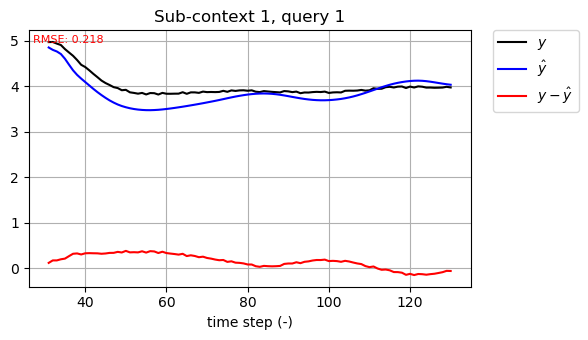

<Figure size 640x480 with 0 Axes>

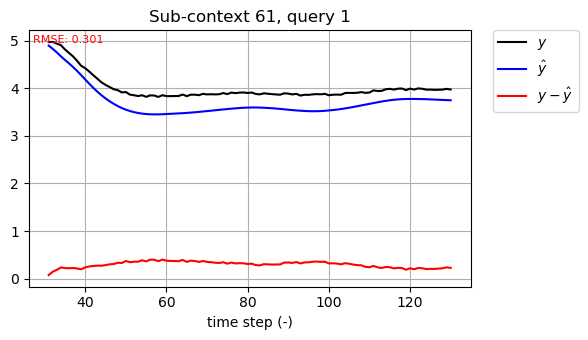

<Figure size 640x480 with 0 Axes>

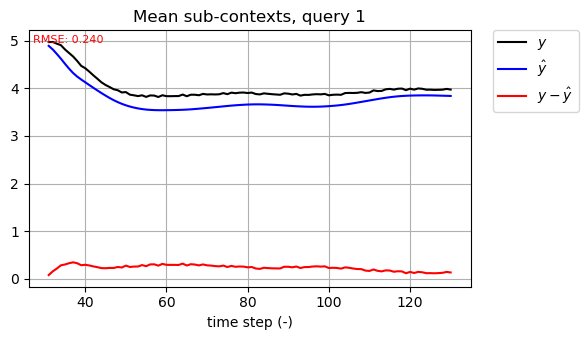

<Figure size 640x480 with 0 Axes>

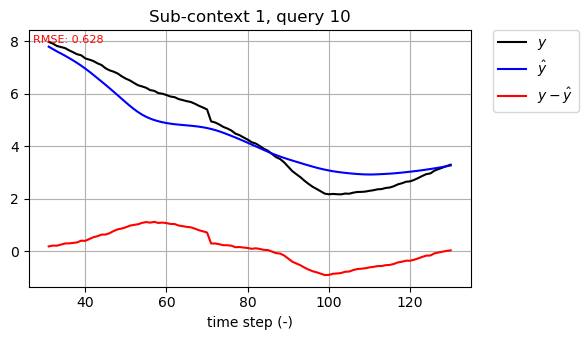

<Figure size 640x480 with 0 Axes>

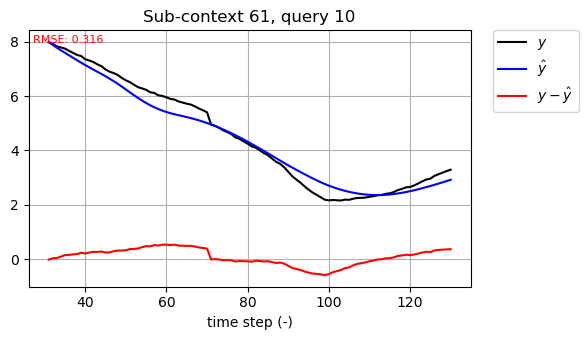

<Figure size 640x480 with 0 Axes>

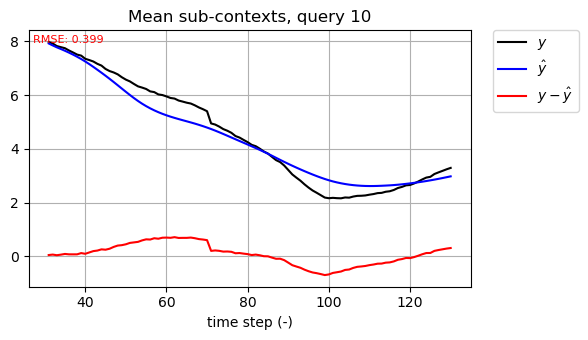

<Figure size 640x480 with 0 Axes>

In [8]:
save_fig = False

queries_rmses = []
for rq in range(n_query):
    for cd in range(ctx_divisions):
        sim_err = ys_true_query[rq, cfg_model.seq_len_n_in:, :] - ys_model[cd, rq, :, :]
        rmse_cd_rq = rmse_mult * RMSE(ys_true_query[rq, cfg_model.seq_len_n_in:, :], ys_model[cd, rq, :, :])[0]

        if (cd == 0 or cd == ctx_divisions - 1) and (rq == 0 or rq == n_query - 1):
            plt.figure(figsize=(6, 3.5))
            t = np.arange(1, cfg_model.seq_len_new + 1) + cfg_model.seq_len_n_in
            plt.plot(t, ys_true_query[rq, cfg_model.seq_len_n_in:, :], 'k', label=r"$y$")
            plt.plot(t, ys_model[cd, rq, :, :], 'b', label=r"$\hat y$")
            plt.plot(t, sim_err, 'r', label=r"$y - \hat y$")
            plt.grid(True)
            plt.title(f"Sub-context {cd+1}, query {rq+1}")
            plt.xlabel("time step (-)")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.text(0.01, 0.95, f'RMSE: {rmse_cd_rq:.3f}', size=8, color='red', transform=plt.gca().transAxes)
            plt.tight_layout()
            plt.show()
            plt.cla()
            plt.clf()

    rmse_cd_mean = rmse_mult * RMSE(ys_true_query[rq, cfg_model.seq_len_n_in:, 0], mean_ctx_ys[rq, :, 0])
    queries_rmses.append(rmse_cd_mean)
    sim_err_mean = ys_true_query[rq, cfg_model.seq_len_n_in:, :] - mean_ctx_ys[rq, :, :]

    if rq == 0 or rq == n_query - 1:
        plt.figure(figsize=(6, 3.5))
        t = np.arange(1, cfg_model.seq_len_new + 1) + cfg_model.seq_len_n_in
        plt.plot(t, ys_true_query[rq, cfg_model.seq_len_n_in:, :], 'k', label=r"$y$")
        plt.plot(t, mean_ctx_ys[rq, :, :], 'b', label=r"$\hat y$")
        plt.plot(t, sim_err_mean, 'r', label=r"$y - \hat y$")
        plt.grid(True)
        plt.title(f"Mean sub-contexts, query {rq+1}")
        plt.xlabel("time step (-)")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.text(0.01, 0.95, f'RMSE: {rmse_cd_mean:.3f}', size=8, color='red',
                 transform=plt.gca().transAxes)
        plt.tight_layout()
        plt.show()
        plt.cla()
        plt.clf()


In [9]:
queries_trues = ys_true_query[:, cfg_model.seq_len_n_in:, 0].reshape(n_query*cfg_model.seq_len_new)
queries_model = ys_model[:, :, :, 0].reshape(ctx_divisions, n_query*cfg_model.seq_len_new)
queries_model_mean_ctx = mean_ctx_ys[:, :, 0].reshape(n_query*cfg_model.seq_len_new)
queries_err = queries_trues - queries_model_mean_ctx
rmse_mean_all_queries = rmse_mult * RMSE(queries_trues, queries_model_mean_ctx)
queries_variance_inv = variance_invs[:, :, :, 0].reshape(ctx_divisions, n_query*cfg_model.seq_len_new)
queries_input = us_query[:, cfg_model.seq_len_n_in:, 0].reshape(n_query*cfg_model.seq_len_new)

sum_var_inv = np.sum(queries_variance_inv, axis=0)
queries_weighted_ensambling = np.sum(ys_model[:, :, :, 0].reshape(ctx_divisions, n_query*cfg_model.seq_len_new) *
                                     queries_variance_inv, axis=0) / sum_var_inv

rmse_weighted_ensamble = rmse_mult * RMSE(queries_trues, queries_weighted_ensambling)

rmse_ctxs_queries = []
for ctx in range(ctx_divisions):
    rmse_ctxs_queries.append(rmse_mult * RMSE(queries_trues, ys_model[ctx, :, :, 0].reshape(n_query*cfg_model.seq_len_new)))
mean_rmse_no_ensambling = np.mean(rmse_ctxs_queries)
median_rmse_no_ensambling = np.median(rmse_ctxs_queries)

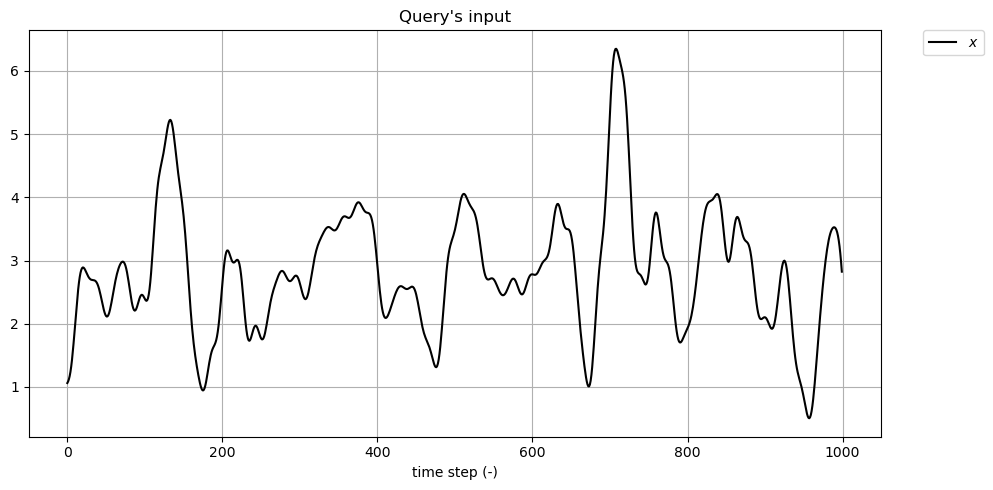

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(queries_input, 'k', label=r"$x$")
plt.grid(True)
plt.title(f"Query's input")
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
if save_fig:
    plt.savefig(f"fig/BENCHMARK_ctx{cfg_model.seq_len_ctx}_input")
plt.show()
plt.cla()
plt.clf()

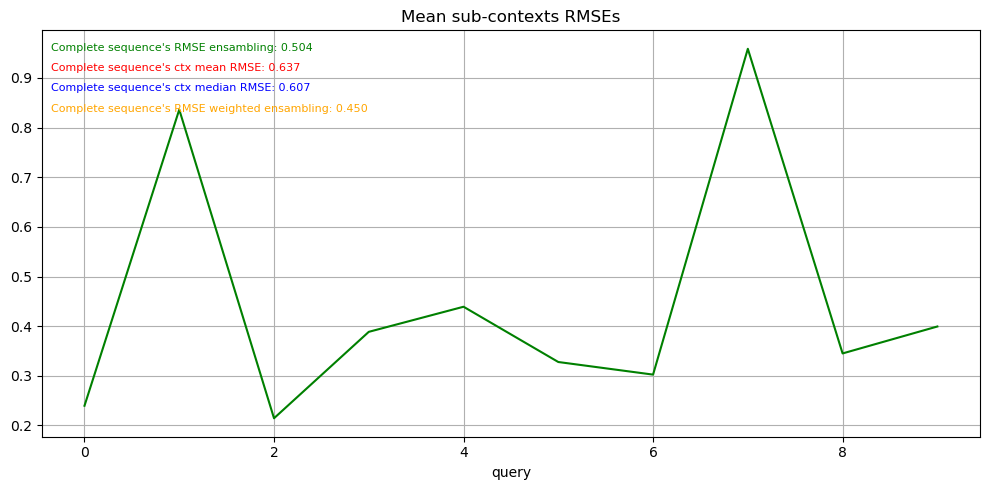

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(queries_rmses, c='g')
plt.grid(True)
plt.title(f"Mean sub-contexts RMSEs")
plt.xlabel("query")
plt.text(0.01, 0.95, f'Complete sequence\'s RMSE ensambling: {rmse_mean_all_queries:.3f}', size=8, color='green',
         transform=plt.gca().transAxes)
plt.text(0.01, 0.90, f'Complete sequence\'s ctx mean RMSE: {mean_rmse_no_ensambling:.3f}', size=8, color='red',
         transform=plt.gca().transAxes)
plt.text(0.01, 0.85, f'Complete sequence\'s ctx median RMSE: {median_rmse_no_ensambling:.3f}', size=8, color='blue',
         transform=plt.gca().transAxes)
plt.text(0.01, 0.80, f'Complete sequence\'s RMSE weighted ensambling: {rmse_weighted_ensamble:.3f}', size=8,
         color='orange',
         transform=plt.gca().transAxes)
plt.tight_layout()
if save_fig:
    plt.savefig(f"fig/BENCHMARK_ctx{cfg_model.seq_len_ctx}_rmse_all_queries")
plt.show()
plt.cla()
plt.clf()

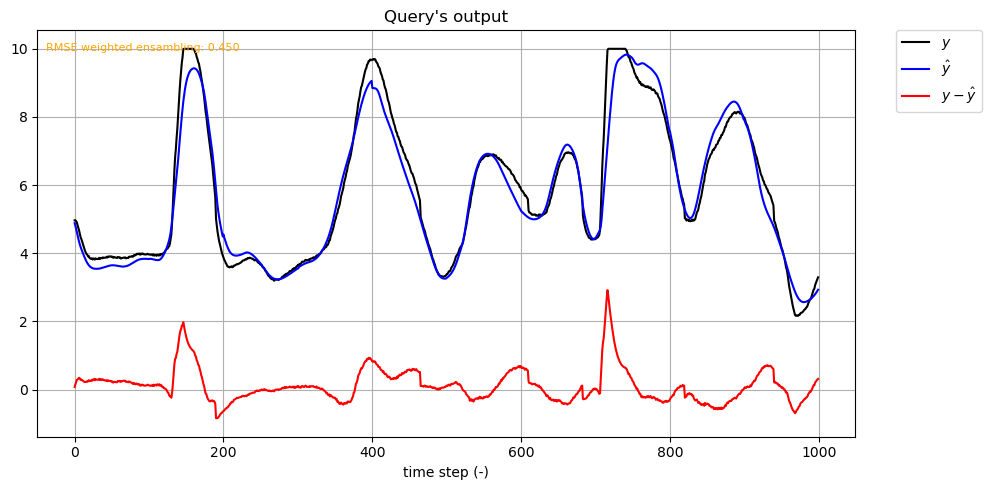

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 5))
t = np.arange(0, n_query * cfg_model.seq_len_new)
plt.plot(t, queries_trues, 'k', label=r"$y$")
# plt.plot(t, queries_model_mean_ctx, 'b', label="$\hat y$")
plt.plot(t, queries_weighted_ensambling, 'b', label=r"$\hat y$")
plt.plot(t, queries_err, 'r', label=r"$y - \hat y$")
plt.grid(True)
plt.title(f"Query's output")
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.text(0.01, 0.95, f'RMSE ensambling: {rmse_mean_all_queries:.3f}', size=8, color='green', transform=plt.gca().transAxes)
plt.text(0.01, 0.95, f'RMSE weighted ensambling: {rmse_weighted_ensamble:.3f}', size=8, color='orange', transform=plt.gca().transAxes)
plt.tight_layout()
if save_fig:
    plt.savefig(f"fig/BENCHMARK_ctx{cfg_model.seq_len_ctx}_all_queries")
plt.show()
plt.cla()
plt.clf()